In [1]:
import pandas as pd

df = pd.read_csv('anime.csv')

# Display the first few rows of the DataFrame to understand its structure
df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [2]:
df.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [3]:
# Replace missing values in 'genre' and 'type' with "Unknown"
df['genre'].fillna('Unknown', inplace=True)
df['type'].fillna('Unknown', inplace=True)

# Replace missing values in 'rating' with the mean rating of the dataset
mean_rating = df['rating'].mean()
df['rating'].fillna(mean_rating, inplace=True)

# Verify that there are no more missing values
df.isnull().sum()


anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

<ipython-input-4-c4cd0b62d753>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=type_counts.index, y=type_counts.values, palette="viridis")


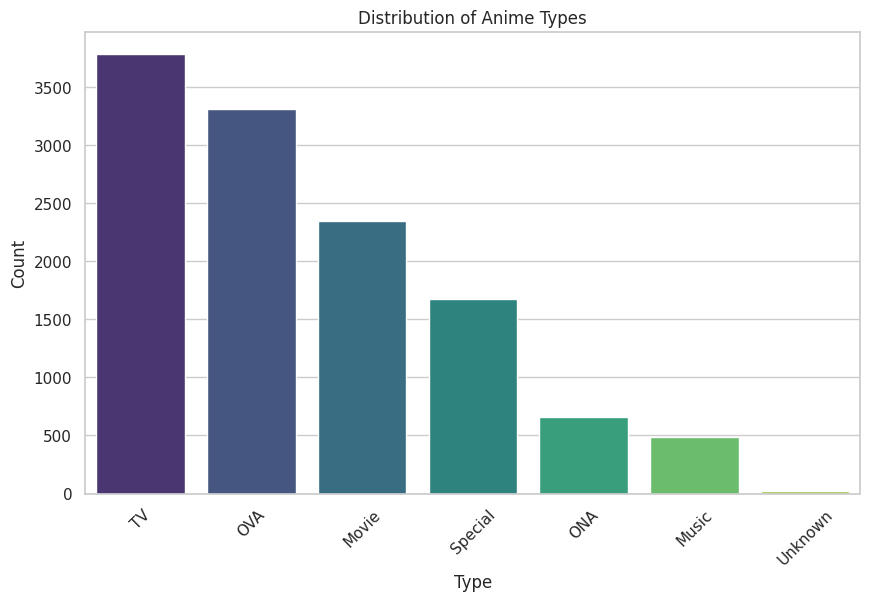

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for seaborn
sns.set(style="whitegrid")

# Distribution of anime types
type_counts = df['type'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=type_counts.index, y=type_counts.values, palette="viridis")
plt.title('Distribution of Anime Types')
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [5]:
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder, MinMaxScaler
# 1. Multi-label binarization for genres
mlb = MultiLabelBinarizer()
genre_bin = mlb.fit_transform(df['genre'].str.split(', '))

In [6]:
# 2. One-hot encoding for type
ohe = OneHotEncoder(sparse=False)
type_encoded = ohe.fit_transform(df[['type']])

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [7]:
# 3. Normalize ratings and number of episodes
scaler = MinMaxScaler()

In [8]:
# Convert episodes to numerical, handling 'Unknown'
df['episodes'] = pd.to_numeric(df['episodes'], errors='coerce').fillna(0)
features_to_normalize = df[['rating', 'episodes']]
normalized_features = scaler.fit_transform(features_to_normalize)

In [9]:
# Combine all features into a single DataFrame
features = pd.DataFrame(genre_bin, columns=mlb.classes_)
features = features.join(pd.DataFrame(type_encoded, columns=ohe.get_feature_names_out()))
features = features.join(pd.DataFrame(normalized_features, columns=['rating', 'episodes']))

In [10]:
features.head()

,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,...,Yuri,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV,type_Unknown,rating,episodes
0,0,0,0,0,0,0,1,0,0,0,...,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.924370,0.000550
1,1,1,0,0,0,0,1,0,1,0,...,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.911164,0.035204
2,1,0,0,1,0,0,0,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.909964,0.028053
3,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.900360,0.013201
4,1,0,0,1,0,0,0,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.899160,0.028053


In [11]:
from sklearn.metrics.pairwise import cosine_similarity
# Compute cosine similarity matrix
cosine_sim_matrix = cosine_similarity(features)

In [12]:
# Function to recommend anime based on cosine similarity
def recommend_anime(anime_name, cosine_sim_matrix, df, threshold=0.5):
    # Find the index of the target anime
    target_index = df[df['name'] == anime_name].index[0]

    # Retrieve the similarity scores for the target anime
    similarity_scores = list(enumerate(cosine_sim_matrix[target_index]))

    # Sort the anime based on similarity scores in descending order
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    # Filter out the target anime itself and apply the threshold
    recommended_indices = [i for i, score in similarity_scores if i != target_index and score >= threshold]

    # Get the names of the recommended anime
    recommended_anime = df.iloc[recommended_indices]['name']

    return recommended_anime


In [13]:
recommend_anime('Kimi no Na wa.', cosine_sim_matrix, df, threshold=0.7)

1111    Aura: Maryuuin Kouga Saigo no Tatakai
208             Kokoro ga Sakebitagatterunda.
1494                                 Harmonie
1959                                Air Movie
60                         Hotarubi no Mori e
                        ...                  
5031                           Mizuiro (2003)
5127                       Venus Versus Virus
5139                  Hana yori Dango (Movie)
5233                       To Heart 2 Special
1604                      Shakugan no Shana S
Name: name, Length: 69, dtype: object

You can experiment with different threshold values to see how the recommendation list changes. For example, use threshold=0.7 for more selective recommendations and threshold=0.5 for broader recommendations.



In [14]:
from sklearn.model_selection import train_test_split
# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [15]:
# Compute features for training data
genre_bin_train = mlb.fit_transform(train_df['genre'].str.split(', '))
type_encoded_train = ohe.fit_transform(train_df[['type']])
features_to_normalize_train = train_df[['rating', 'episodes']]
normalized_features_train = scaler.fit_transform(features_to_normalize_train)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [16]:
# Combine all features into a single DataFrame for training data
train_features = pd.DataFrame(genre_bin_train, columns=mlb.classes_)
train_features = train_features.join(pd.DataFrame(type_encoded_train, columns=ohe.get_feature_names_out()))
train_features = train_features.join(pd.DataFrame(normalized_features_train, columns=['rating', 'episodes']))

In [17]:
# Compute cosine similarity matrix for training data
cosine_sim_matrix_train = cosine_similarity(train_features)

In [24]:
# Function to recommend anime based on cosine similarity
def recommend_anime(anime_name, cosine_sim_matrix, df, threshold=0.5):
    # Check if the anime name exists in the DataFrame
    if anime_name not in df['name'].values:
        print(f"Anime '{anime_name}' not found in the dataset.")
        return []

    # Find the index of the target anime
    target_index = df[df['name'] == anime_name].index[0]
    if len(target_index) == 0:
        print(f"Anime '{anime_name}' not found in the dataset.")
        return []

    target_index = target_index[0]

    # Retrieve the similarity scores for the target anime
    similarity_scores = list(enumerate(cosine_sim_matrix[target_index]))

    # Sort the anime based on similarity scores in descending order
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    # Filter out the target anime itself and apply the threshold
    recommended_indices = [i for i, score in similarity_scores if i != target_index and score >= threshold]

    # Get the names of the recommended anime
    recommended_anime = df.iloc[recommended_indices]['name']if recommended_indices else[]

    return recommended_anime


In [25]:
# Function to evaluate the recommendation system
def evaluate_recommendation_system(train_df, test_df, cosine_sim_matrix_train, threshold=0.5):
    true_positive = 0
    false_positive = 0
    false_negative = 0

    for idx, row in test_df.iterrows():
        recommended_anime = recommend_anime(row['name'], cosine_sim_matrix_train, train_df, threshold)

        # Continue if no recommendations are made
        if not recommended_anime:
            continue

        relevant_anime = test_df[test_df['name'].isin(recommended_anime)]

        true_positive += len(relevant_anime)
        false_positive += len(recommended_anime) - len(relevant_anime)
        false_negative += len(test_df) - len(relevant_anime)

    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1

# Evaluate the recommendation system
precision, recall, f1 = evaluate_recommendation_system(train_df, test_df, cosine_sim_matrix_train, threshold=0.7)

precision, recall, f1

Anime 'Suzy&#039;s Zoo: Daisuki! Witzy - Happy Birthday' not found in the dataset.
Anime 'Tactics' not found in the dataset.
Anime 'Kamen no Maid Guy' not found in the dataset.
Anime 'Take Your Way' not found in the dataset.
Anime 'Rinkaku' not found in the dataset.
Anime 'Suisei no Gargantia: Meguru Kouro, Haruka' not found in the dataset.
Anime 'Digital Devil Story: Megami Tensei' not found in the dataset.
Anime 'Chuunibyou demo Koi ga Shitai! Ren Lite' not found in the dataset.
Anime 'Kobo-chan' not found in the dataset.
Anime 'Sekaiichi Hatsukoi Movie: Yokozawa Takafumi no Baai' not found in the dataset.
Anime 'Mardock Scramble: The Second Combustion' not found in the dataset.
Anime 'Yukiguni no Oujisama' not found in the dataset.
Anime 'Mugen Senshi Valis' not found in the dataset.
Anime 'Cyborg 009: Call of Justice 1' not found in the dataset.
Anime 'Demi-chan wa Kataritai' not found in the dataset.
Anime 'Ane Koi: Suki Kirai Daisuki.' not found in the dataset.
Anime 'Chrome Shel

(0, 0, 0)


Interview Questions:
1. Can you explain the difference between user-based and item-based collaborative filtering?


User-Based Collaborative Filtering
Concept: This approach recommends items to a user based on the preferences of other users who are similar to them.

Steps:

Identify Similar Users: Calculate the similarity between users based on their rating patterns. Common methods include cosine similarity, Pearson correlation, and others.
Select Neighbors: Choose a set of users who have the highest similarity to the target user.
Generate Recommendations: Aggregate the preferences of these similar users to recommend items that the target user has not yet rated or interacted with.
Example:

If User A and User B both like Item 1 and Item 2, and User A also likes Item 3, then User B is likely to like Item 3 as well.
Item-Based Collaborative Filtering
Concept: This approach recommends items based on the similarity between items. It focuses on finding items similar to those that the user has liked or interacted with.

Steps:

Identify Similar Items: Calculate the similarity between items based on user ratings. Again, methods like cosine similarity or Pearson correlation are commonly used.
Generate Item Similarity Matrix: Create a matrix where each entry represents the similarity between two items.
Recommend Items: For a given user, recommend items that are similar to the items they have already rated highly or interacted with.
Example:

If Item A and Item B are frequently liked by the same users, and a user likes Item A, then the system will recommend Item B to that user.
Differences
Focus:

User-Based: Focuses on finding similar users.
Item-Based: Focuses on finding similar items.
Similarity Calculation:

User-Based: Similarity is calculated between users based on their item preferences.
Item-Based: Similarity is calculated between items based on user ratings.
Scalability:

User-Based: Can be less scalable for large datasets with many users, as calculating similarities between all pairs of users can be computationally expensive.
Item-Based: Often more scalable since the number of items is usually less than the number of users, and items tend to have more stable rating patterns over time.
Cold Start Problem:

User-Based: Suffers from the cold start problem when a new user joins with no prior ratings.
Item-Based: Suffers from the cold start problem when a new item is added with no prior ratings.
Dynamic Nature:

User-Based: Can adapt quickly to changes in user preferences.
Item-Based: Generally more stable as item similarities don't change as frequently.
When to Use Each
User-Based: More suitable when the user base is small but has many interactions or ratings.
Item-Based: Preferred when there are more users than items, or when the items' ratings are stable over time.


2. What is collaborative filtering, and how does it work?

Collaborative filtering is a method used in recommendation systems to predict a user's interest in items based on the preferences and behaviors of other users. The fundamental idea is that users who have agreed in the past will agree in the future. Collaborative filtering can be divided into two main types: user-based collaborative filtering and item-based collaborative filtering.

How Collaborative Filtering Works
Data Collection
Collaborative filtering relies on collecting user interactions with items. These interactions can be explicit (e.g., ratings, likes, reviews) or implicit (e.g., clicks, purchase history).

Creating a Utility Matrix
A utility matrix is constructed where rows represent users and columns represent items. The matrix entries indicate the interaction between users and items. For example:

mathematica
Copy code
          | Item 1 | Item 2 | Item 3 | Item 4 |
User 1    |   5    |   3    |   ?    |   1    |
User 2    |   4    |   ?    |   4    |   2    |
User 3    |   ?    |   5    |   3    |   3    |
User 4    |   2    |   1    |   2    |   5    |